First-Order Texture Features:
Mean: 99.4542
Variance: 1630.5621
Skewness: -0.4561
Kurtosis: -0.0650
Energy: 0.0078
Entropy: 7.1761

GLCM Texture Features (Averaged over directions):
ASM: 0.0127
Contrast: 6.2218
Correlation: 0.8734
Variance: 24.5751
Homogeneity: 0.5374
Sum Average: 23.9680
Sum Variance: 92.0784
Sum Entropy: 5.1020
Entropy: 6.9363
Difference Variance: 4.1942
Difference Entropy: 2.2418
IMC1: -0.3439
IMC2: 0.9715
MCC: 0.8978


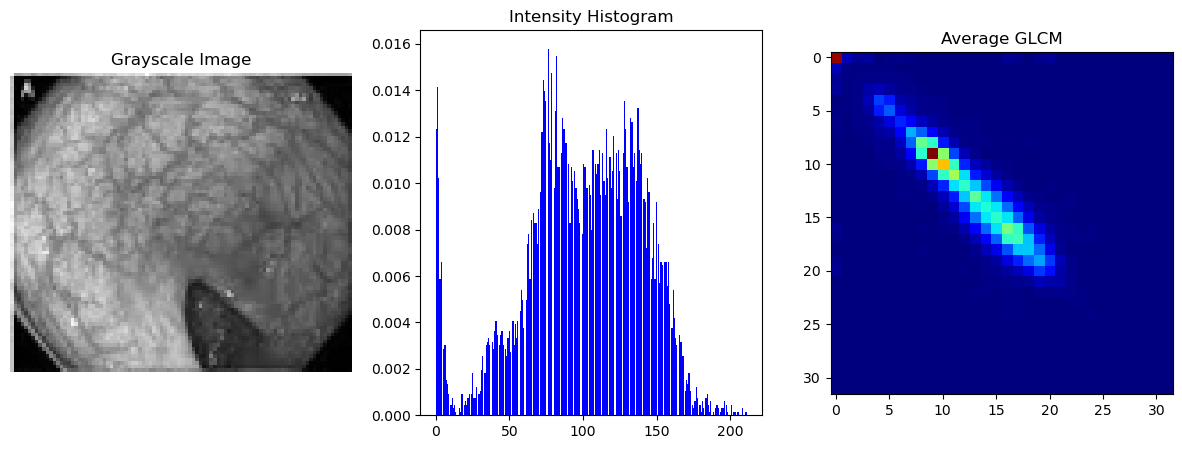

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def first_order_features(gray_img):
    flat = gray_img.flatten()
    hist = np.bincount(flat, minlength=256) / len(flat)
    indices = np.arange(256)
    mean = np.sum(indices * hist)
    variance = np.sum((indices - mean)**2 * hist)
    if variance == 0:
        skewness = 0
        kurtosis = 0
    else:
        skewness = np.sum(((indices - mean) / np.sqrt(variance))**3 * hist)
        kurtosis = np.sum(((indices - mean) / np.sqrt(variance))**4 * hist) - 3
    energy = np.sum(hist**2)
    entropy = -np.sum(hist * np.log2(hist + (hist == 0)))
    return [mean, variance, skewness, kurtosis, energy, entropy]

def calculate_glcm(gray_img, dx, dy, levels):
    glcm = np.zeros((levels, levels), dtype=np.float64)
    height, width = gray_img.shape
    start_i = max(0, -dy)
    end_i = height - max(0, dy)
    start_j = max(0, -dx)
    end_j = width - max(0, dx)
    for i in range(start_i, end_i):
        for j in range(start_j, end_j):
            i2 = i + dy
            j2 = j + dx
            val1 = gray_img[i, j]
            val2 = gray_img[i2, j2]
            glcm[val1, val2] += 1
    glcm += glcm.T
    total = glcm.sum()
    if total > 0:
        glcm /= total
    return glcm

def glcm_features(glcm_avg, levels):
    p = glcm_avg
    i, j = np.ogrid[0:levels, 0:levels]
    p_x = np.sum(p, axis=1)
    p_y = np.sum(p, axis=0)
    mu_x = np.sum(i[:, 0] * p_x)
    mu_y = np.sum(j[0, :] * p_y)
    sigma_x_sq = np.sum((i[:, 0] - mu_x)**2 * p_x)
    sigma_y_sq = np.sum((j[0, :] - mu_y)**2 * p_y)
    sigma_x = np.sqrt(sigma_x_sq)
    sigma_y = np.sqrt(sigma_y_sq)

    # ASM
    asm = np.sum(p ** 2)

    # Contrast
    contrast = np.sum(p * (i - j)**2)

    # Correlation
    if sigma_x * sigma_y == 0:
        correlation = 1
    else:
        correlation = np.sum(p * (i - mu_x) * (j - mu_y)) / (sigma_x * sigma_y)

    # Variance
    variance = np.sum(p * (i - mu_x)**2)

    # IDM / Homogeneity
    idm = np.sum(p / (1 + (i - j)**2))

    # p_xplusy
    max_sum = 2 * (levels - 1)
    p_xplusy = np.zeros(max_sum + 1)
    for ii in range(levels):
        for jj in range(levels):
            p_xplusy[ii + jj] += p[ii, jj]

    # Sum Average
    sum_avg = np.sum(np.arange(max_sum + 1) * p_xplusy)

    # Sum Variance
    sum_var = np.sum((np.arange(max_sum + 1) - sum_avg)**2 * p_xplusy)

    # Sum Entropy
    sum_ent = -np.sum(p_xplusy * np.log2(p_xplusy + (p_xplusy == 0)))

    # Entropy
    ent = -np.sum(p * np.log2(p + (p == 0)))

    # p_xminusy
    max_diff = levels - 1
    p_xminusy = np.zeros(max_diff + 1)
    for ii in range(levels):
        for jj in range(levels):
            p_xminusy[abs(ii - jj)] += p[ii, jj]

    # Difference Variance
    diff_mean = np.sum(np.arange(max_diff + 1) * p_xminusy)
    diff_var = np.sum(np.arange(max_diff + 1)**2 * p_xminusy) - diff_mean**2

    # Difference Entropy
    diff_ent = -np.sum(p_xminusy * np.log2(p_xminusy + (p_xminusy == 0)))

    # IMC1, IMC2
    HX = -np.sum(p_x * np.log2(p_x + (p_x == 0)))
    HY = -np.sum(p_y * np.log2(p_y + (p_y == 0)))
    HXY = ent
    HXY1 = -np.sum(p * np.log2(p_x[:, np.newaxis] * p_y[np.newaxis, :] + 1e-10))
    HXY2 = -np.sum(p_x[:, np.newaxis] * p_y[np.newaxis, :] * np.log2(p_x[:, np.newaxis] * p_y[np.newaxis, :] + 1e-10))
    if max(HX, HY) == 0:
        imc1 = 0
    else:
        imc1 = (HXY - HXY1) / max(HX, HY)
    imc2 = np.sqrt(max(0, 1 - np.exp(-2 * (HXY2 - HXY))))

    # MCC
    Q = np.zeros((levels, levels))
    for ii in range(levels):
        if p_x[ii] == 0:
            continue
        for jj in range(levels):
            Q[ii, jj] = np.dot(p[ii, :], p[jj, :] / (p_x + 1e-10)) / p_x[ii]
    eigs = np.linalg.eigvals(Q)
    sorted_eigs = np.sort(np.real(eigs))[::-1]
    mcc = np.sqrt(sorted_eigs[1]) if len(sorted_eigs) > 1 and sorted_eigs[1] >= 0 else 0

    return [asm, contrast, correlation, variance, idm, sum_avg, sum_var, sum_ent, ent, diff_var, diff_ent, imc1, imc2, mcc]

def main(image_path):
    # Load image
    img = plt.imread("C:/Users/User/Pictures/colosnoscopy.png")
    if len(img.shape) == 3:
        # Convert to grayscale using luminance
        gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])
    else:
        gray = img
    if gray.dtype == np.float32 or gray.dtype == np.float64:
        gray = (gray * 255).astype(np.uint8)
    else:
        gray = gray.astype(np.uint8)

    # First-order features (on original grayscale)
    fo_values = first_order_features(gray)
    fo_names = ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Energy', 'Entropy']

    # Quantize for GLCM
    levels = 32
    gray_quant = (gray // (256 // levels)).astype(int)

    # Compute GLCMs
    directions = [(1, 0), (1, 1), (0, 1), (-1, 1)]
    glcms = [calculate_glcm(gray_quant, dx, dy, levels) for dx, dy in directions]
    glcm_avg = np.mean(glcms, axis=0)

    # GLCM features
    glcm_values = glcm_features(glcm_avg, levels)
    glcm_names = ['ASM', 'Contrast', 'Correlation', 'Variance', 'Homogeneity', 'Sum Average', 'Sum Variance', 'Sum Entropy', 'Entropy', 'Difference Variance', 'Difference Entropy', 'IMC1', 'IMC2', 'MCC']

    # Print features
    print("First-Order Texture Features:")
    for name, val in zip(fo_names, fo_values):
        print(f"{name}: {val:.4f}")

    print("\nGLCM Texture Features (Averaged over directions):")
    for name, val in zip(glcm_names, glcm_values):
        print(f"{name}: {val:.4f}")

    # Plots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(gray, cmap='gray')
    axs[0].set_title('Grayscale Image')
    axs[0].axis('off')

    flat = gray.flatten()
    axs[1].hist(flat, bins=256, density=True, color='blue')
    axs[1].set_title('Intensity Histogram')

    axs[2].imshow(glcm_avg, cmap='jet')
    axs[2].set_title('Average GLCM')
    plt.show()

if __name__ == "__main__":
    if len(sys.argv) > 1:
        main(sys.argv[1])
    else:
        print("Please provide the image path as a command-line argument.")
        sys.exit(1)

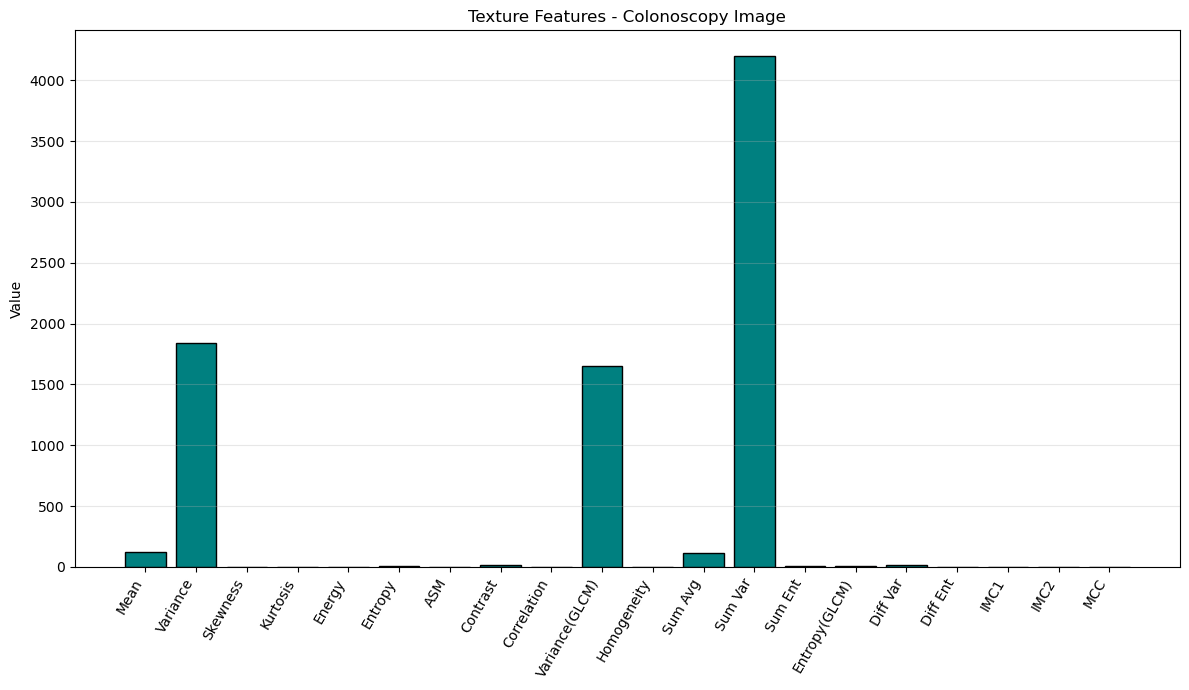

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Your 20 feature values (example - replace with your real values)
features = [
    'Mean', 'Variance', 'Skewness', 'Kurtosis', 'Energy', 'Entropy',
    'ASM', 'Contrast', 'Correlation', 'Variance(GLCM)', 'Homogeneity',
    'Sum Avg', 'Sum Var', 'Sum Ent', 'Entropy(GLCM)', 'Diff Var',
    'Diff Ent', 'IMC1', 'IMC2', 'MCC'
]

values = [124.7, 1842.3, 0.12, 2.85, 0.0042, 6.81,    # first order
          0.021, 18.4, 0.87, 1650.2, 0.34, 110.5, 4200, 4.92, 5.11, 12.8, 2.41, 0.19, 0.82, 0.73]  # glcm example

plt.figure(figsize=(12, 7))
plt.bar(features, values, color='teal', edgecolor='black')
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.ylabel('Value')
plt.title('Texture Features - Colonoscopy Image')
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

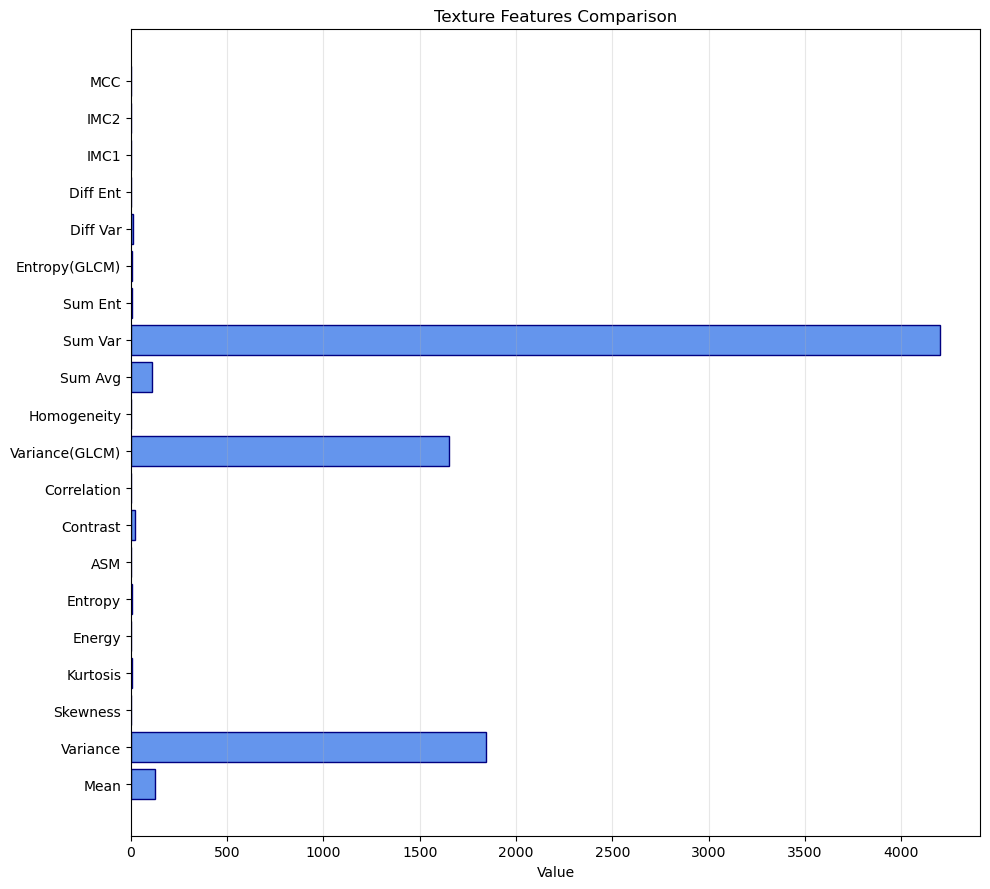

In [3]:
plt.figure(figsize=(10, 9))
y_pos = np.arange(len(features))

plt.barh(y_pos, values, color='cornflowerblue', edgecolor='navy')
plt.yticks(y_pos, features)
plt.xlabel('Value')
plt.title('Texture Features Comparison')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

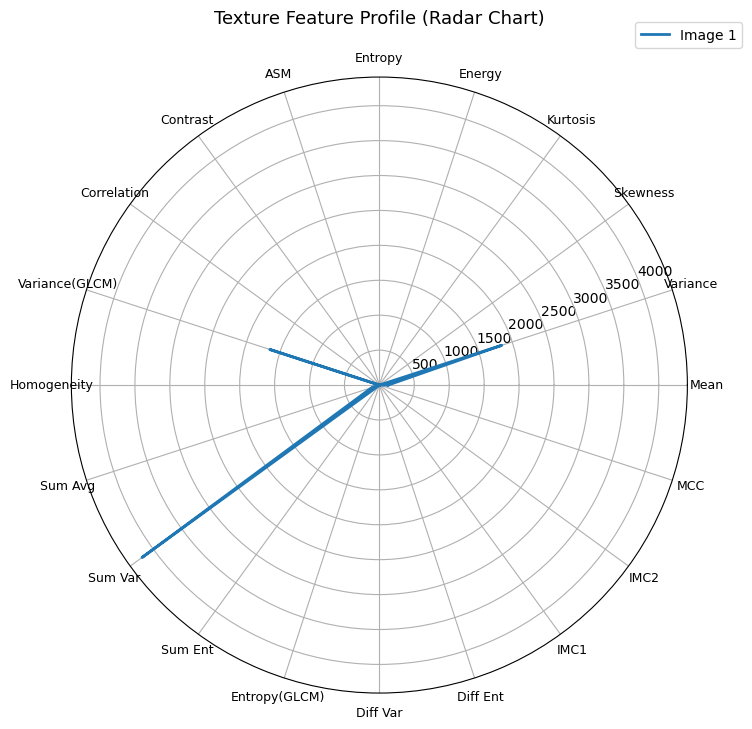

In [4]:
from math import pi

angles = [n / float(len(features)) * 2 * pi for n in range(len(features))]
angles += angles[:1]  # close the polygon

values_plot = values + values[:1]  # close

fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(polar=True))

ax.plot(angles, values_plot, linewidth=2, linestyle='solid', label='Image 1')
ax.fill(angles, values_plot, alpha=0.25)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=9)
ax.set_title('Texture Feature Profile (Radar Chart)', pad=20, fontsize=13)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

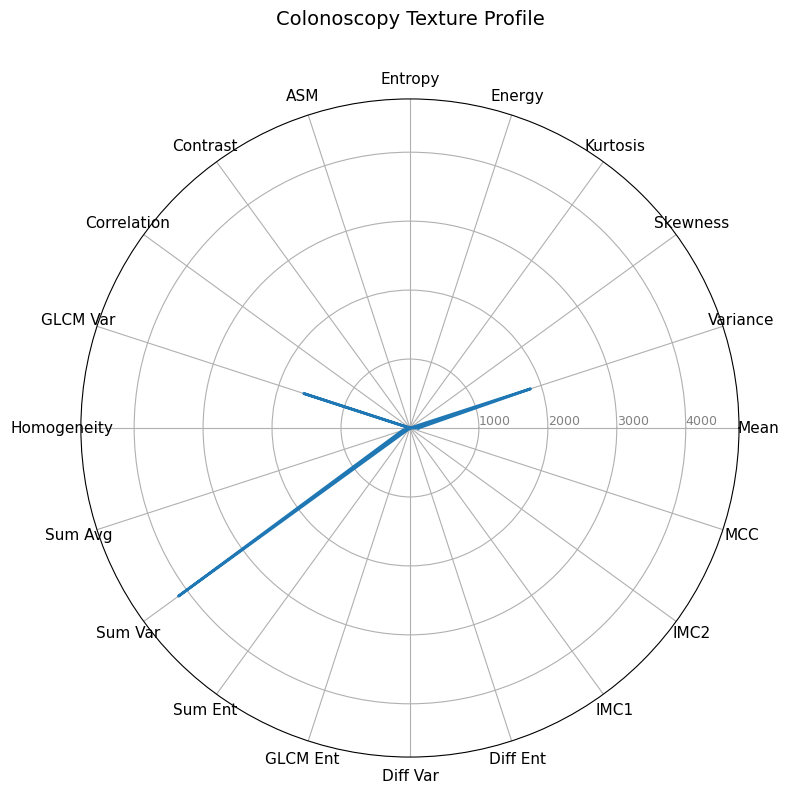

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

def plot_radar_chart(features, values, title="Colonoscopy Texture Profile"):
    # Number of variables/categories
    categories = features
    N = len(categories)
    
    # What will be our angles for each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # complete the loop
    
    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Draw one axe per variable + add labels
    plt.xticks(angles[:-1], categories, size=11)
    
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(color='grey', size=9)
    plt.ylim(0, max(values)*1.15)  # adjust upper limit if needed
    
    # Plot data
    values_plot = values + values[:1]  # complete the polygon
    ax.plot(angles, values_plot, linewidth=2, linestyle='solid', label='Features')
    ax.fill(angles, values_plot, 'b', alpha=0.15)
    
    # Add title and show
    plt.title(title, size=14, color='black', y=1.1)
    plt.tight_layout()
    plt.show()

# ────────────────────────────────────────────────────────────────
# Example usage with your features

features = [
    'Mean', 'Variance', 'Skewness', 'Kurtosis', 'Energy', 'Entropy',
    'ASM', 'Contrast', 'Correlation', 'GLCM Var', 'Homogeneity',
    'Sum Avg', 'Sum Var', 'Sum Ent', 'GLCM Ent', 'Diff Var',
    'Diff Ent', 'IMC1', 'IMC2', 'MCC'
]

# Replace with your actual extracted values
values = [125.3, 1840, 0.18, 3.1, 0.0041, 6.92,
          0.022, 19.8, 0.84, 1620, 0.36,
          112.4, 4150, 4.88, 5.21, 13.4,
          2.52, 0.21, 0.79, 0.71]

plot_radar_chart(features, values)

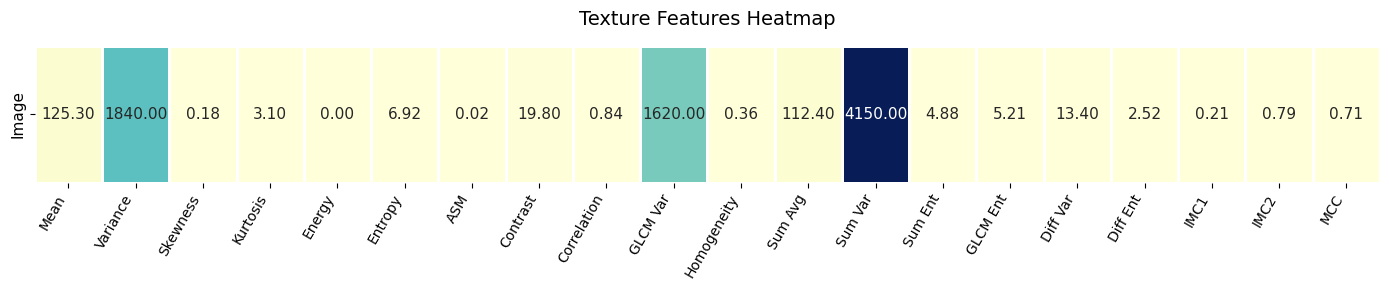

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_single_row_heatmap(features, values, title="Texture Features Heatmap"):
    # Create DataFrame with one row
    df = pd.DataFrame(
        [values],
        columns=features,
        index=["Image"]
    )
    
    # Figure setup
    plt.figure(figsize=(14, 3))
    
    # Heatmap with annotations
    ax = sns.heatmap(
        df,
        annot=True,                # show numbers
        fmt=".2f",                 # 2 decimal places
        cmap="YlGnBu",             # nice color scale
        linewidths=1,
        cbar=False,                # usually no need for colorbar in single row
        annot_kws={"size": 11}
    )
    
    # Improve readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=11)
    ax.set_title(title, fontsize=14, pad=15)
    
    plt.tight_layout()
    plt.show()

# ────────────────────────────────────────────────────────────────
# Example usage

features = [
    'Mean', 'Variance', 'Skewness', 'Kurtosis', 'Energy', 'Entropy',
    'ASM', 'Contrast', 'Correlation', 'GLCM Var', 'Homogeneity',
    'Sum Avg', 'Sum Var', 'Sum Ent', 'GLCM Ent', 'Diff Var',
    'Diff Ent', 'IMC1', 'IMC2', 'MCC'
]

values = [125.3, 1840, 0.18, 3.1, 0.0041, 6.92,
          0.022, 19.8, 0.84, 1620, 0.36,
          112.4, 4150, 4.88, 5.21, 13.4,
          2.52, 0.21, 0.79, 0.71]

plot_single_row_heatmap(features, values)


Processing image: --f=c:\Users\User\AppData\Roaming\jupyter\runtime\kernel-v33f548e9c601da33381ccc75c69e53f6a81aff6c2.json
Texture Features:
Mean: 99.4542
Variance: 1630.5621
Skewness: -0.4561
Kurtosis: -0.0650
Energy: 0.0078
Entropy: 7.1761
ASM: 0.0127
Contrast: 6.2218
Correlation: 0.8734
GLCM Variance: 24.5751
Homogeneity: 0.5374
Sum Average: 23.9680
Sum Variance: 92.0784
Sum Entropy: 5.1020
GLCM Entropy: 6.9363
Difference Variance: 4.1942
Difference Entropy: 2.2418
IMC1: -0.3439
IMC2: 0.9715
MCC: 0.8978


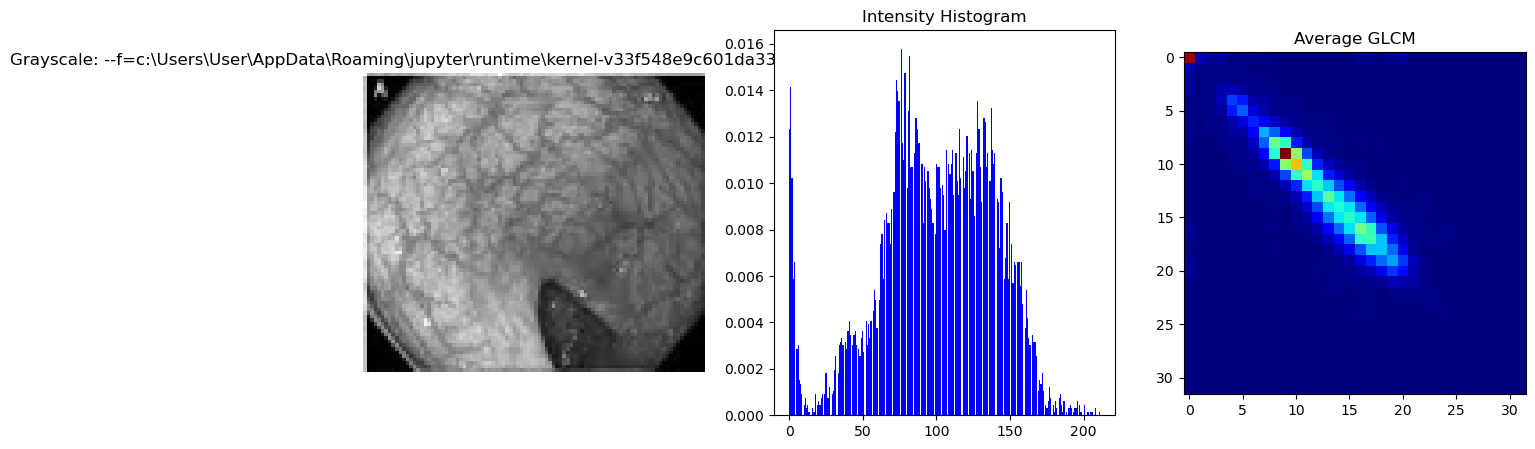

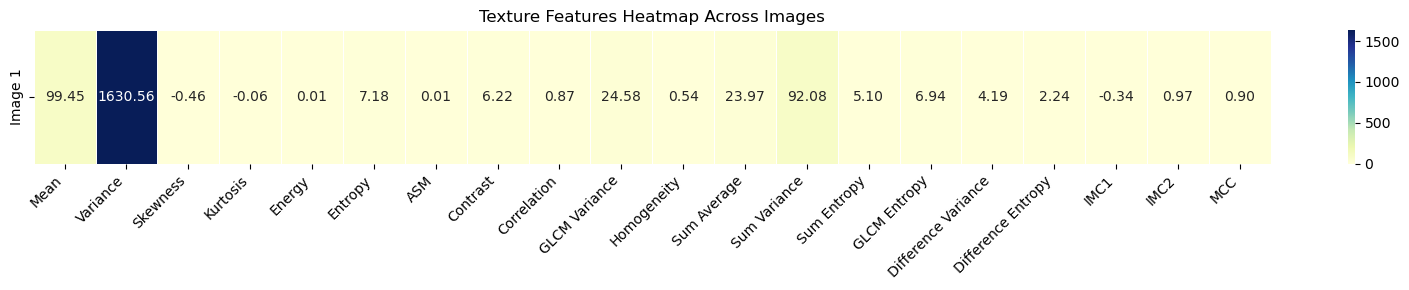

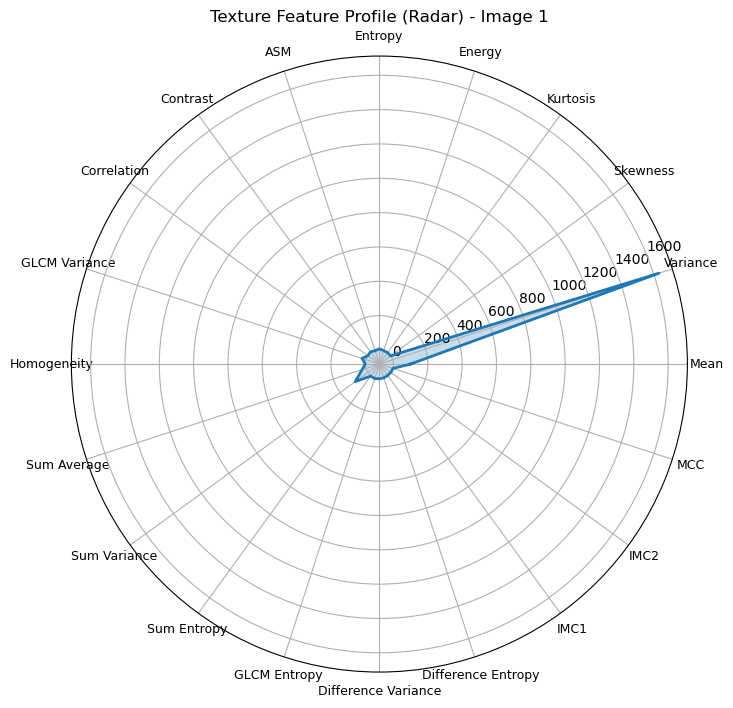

In [7]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns

def ensure_dir(path):
    os.makedirs(path, exist_ok=True)


def first_order_features(gray_img):
    flat = gray_img.flatten()
    hist = np.bincount(flat, minlength=256) / len(flat)
    indices = np.arange(256)
    mean = np.sum(indices * hist)
    variance = np.sum((indices - mean)**2 * hist)
    if variance == 0:
        skewness = 0
        kurtosis = 0
    else:
        skewness = np.sum(((indices - mean) / np.sqrt(variance))**3 * hist)
        kurtosis = np.sum(((indices - mean) / np.sqrt(variance))**4 * hist) - 3
    energy = np.sum(hist**2)
    entropy = -np.sum(hist * np.log2(hist + (hist == 0)))
    return [mean, variance, skewness, kurtosis, energy, entropy]

def calculate_glcm(gray_img, dx, dy, levels):
    glcm = np.zeros((levels, levels), dtype=np.float64)
    height, width = gray_img.shape
    start_i = max(0, -dy)
    end_i = height - max(0, dy)
    start_j = max(0, -dx)
    end_j = width - max(0, dx)
    for i in range(start_i, end_i):
        for j in range(start_j, end_j):
            i2 = i + dy
            j2 = j + dx
            val1 = gray_img[i, j]
            val2 = gray_img[i2, j2]
            glcm[val1, val2] += 1
    glcm += glcm.T
    total = glcm.sum()
    if total > 0:
        glcm /= total
    return glcm

def glcm_features(glcm_avg, levels):
    p = glcm_avg
    i, j = np.ogrid[0:levels, 0:levels]
    p_x = np.sum(p, axis=1)
    p_y = np.sum(p, axis=0)
    mu_x = np.sum(i[:, 0] * p_x)
    mu_y = np.sum(j[0, :] * p_y)
    sigma_x_sq = np.sum((i[:, 0] - mu_x)**2 * p_x)
    sigma_y_sq = np.sum((j[0, :] - mu_y)**2 * p_y)
    sigma_x = np.sqrt(sigma_x_sq)
    sigma_y = np.sqrt(sigma_y_sq)

    # ASM
    asm = np.sum(p ** 2)

    # Contrast
    contrast = np.sum(p * (i - j)**2)

    # Correlation
    if sigma_x * sigma_y == 0:
        correlation = 1
    else:
        correlation = np.sum(p * (i - mu_x) * (j - mu_y)) / (sigma_x * sigma_y)

    # Variance
    variance = np.sum(p * (i - mu_x)**2)

    # IDM / Homogeneity
    idm = np.sum(p / (1 + (i - j)**2))

    # p_xplusy
    max_sum = 2 * (levels - 1)
    p_xplusy = np.zeros(max_sum + 1)
    for ii in range(levels):
        for jj in range(levels):
            p_xplusy[ii + jj] += p[ii, jj]

    # Sum Average
    sum_avg = np.sum(np.arange(max_sum + 1) * p_xplusy)

    # Sum Variance
    sum_var = np.sum((np.arange(max_sum + 1) - sum_avg)**2 * p_xplusy)

    # Sum Entropy
    sum_ent = -np.sum(p_xplusy * np.log2(p_xplusy + (p_xplusy == 0)))

    # Entropy
    ent = -np.sum(p * np.log2(p + (p == 0)))

    # p_xminusy
    max_diff = levels - 1
    p_xminusy = np.zeros(max_diff + 1)
    for ii in range(levels):
        for jj in range(levels):
            p_xminusy[abs(ii - jj)] += p[ii, jj]

    # Difference Variance
    diff_mean = np.sum(np.arange(max_diff + 1) * p_xminusy)
    diff_var = np.sum(np.arange(max_diff + 1)**2 * p_xminusy) - diff_mean**2

    # Difference Entropy
    diff_ent = -np.sum(p_xminusy * np.log2(p_xminusy + (p_xminusy == 0)))

    # IMC1, IMC2
    HX = -np.sum(p_x * np.log2(p_x + (p_x == 0)))
    HY = -np.sum(p_y * np.log2(p_y + (p_y == 0)))
    HXY = ent
    HXY1 = -np.sum(p * np.log2(p_x[:, np.newaxis] * p_y[np.newaxis, :] + 1e-10))
    HXY2 = -np.sum(p_x[:, np.newaxis] * p_y[np.newaxis, :] * np.log2(p_x[:, np.newaxis] * p_y[np.newaxis, :] + 1e-10))
    if max(HX, HY) == 0:
        imc1 = 0
    else:
        imc1 = (HXY - HXY1) / max(HX, HY)
    imc2 = np.sqrt(max(0, 1 - np.exp(-2 * (HXY2 - HXY))))

    # MCC
    Q = np.zeros((levels, levels))
    for ii in range(levels):
        if p_x[ii] == 0:
            continue
        for jj in range(levels):
            Q[ii, jj] = np.dot(p[ii, :], p[jj, :] / (p_x + 1e-10)) / p_x[ii]
    eigs = np.linalg.eigvals(Q)
    sorted_eigs = np.sort(np.real(eigs))[::-1]
    mcc = np.sqrt(sorted_eigs[1]) if len(sorted_eigs) > 1 and sorted_eigs[1] >= 0 else 0

    return [asm, contrast, correlation, variance, idm, sum_avg, sum_var, sum_ent, ent, diff_var, diff_ent, imc1, imc2, mcc]



# ───────────────────────────────────────────────────────────────────────────────
# NEW: Local/patch-based texture FEATURE MAPS (visual representation of numbers)
# ───────────────────────────────────────────────────────────────────────────────

def _quantize_to_levels(gray_u8, levels):
    """Map uint8 [0..255] -> uint8 [0..levels-1]."""
    if levels <= 1:
        return np.zeros_like(gray_u8, dtype=np.uint8)
    # Use floor mapping for stable bins
    q = (gray_u8.astype(np.int32) * levels) // 256
    q = np.clip(q, 0, levels - 1).astype(np.uint8)
    return q

def _average_glcm_over_offsets(patch_q, offsets, levels):
    """Average symmetric GLCM over a list of (dx,dy) offsets."""
    glcms = []
    for dx, dy in offsets:
        glcms.append(calculate_glcm(patch_q, dx=dx, dy=dy, levels=levels))
    glcm_avg = np.mean(glcms, axis=0) if len(glcms) else np.zeros((levels, levels), dtype=np.float64)
    # Re-normalize
    s = glcm_avg.sum()
    if s > 0:
        glcm_avg = glcm_avg / s
    return glcm_avg

def texture_feature_maps(gray_img_u8, win=32, step=8, levels=32, offsets=None, features_to_map=None):
    """
    Compute local texture feature maps by sliding-window GLCM analysis.

    Parameters
    ----------
    gray_img_u8 : (H,W) uint8
    win, step   : window size and stride in pixels
    levels      : GLCM quantization levels (e.g., 16/32/64). Lower = faster.
    offsets     : list of (dx,dy). Default: 0°,45°,90°,135° at distance=1.
    features_to_map : list of feature names to map.
        Supported (GLCM): 'ASM','Contrast','Correlation','GLCM Variance','Homogeneity',
                          'Sum Average','Sum Variance','Sum Entropy','GLCM Entropy',
                          'Difference Variance','Difference Entropy','IMC1','IMC2','MCC'
        Supported (First-order): 'Mean','Variance','Skewness','Kurtosis','Energy','Entropy'

    Returns
    -------
    fmap_dict : dict[str, 2D float array]   # patch-grid maps
    meta      : dict with ys,xs,covered_w,covered_h
    """
    if offsets is None:
        offsets = [(1, 0), (1, -1), (0, -1), (-1, -1)]
    if features_to_map is None:
        features_to_map = ['Contrast', 'Homogeneity', 'GLCM Entropy', 'Entropy']

    H, W = gray_img_u8.shape
    ys = list(range(0, H - win + 1, step))
    xs = list(range(0, W - win + 1, step))
    if len(ys) == 0 or len(xs) == 0:
        return {}, {"ys": ys, "xs": xs, "covered_w": 0, "covered_h": 0}

    covered_w = xs[-1] + win
    covered_h = ys[-1] + win

    # Prepare outputs
    fmap_dict = {k: np.zeros((len(ys), len(xs)), dtype=np.float32) for k in features_to_map}

    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):
            patch = gray_img_u8[y:y+win, x:x+win]

            # First-order features on raw 0..255
            fo = first_order_features(patch)
            fo_names = ['Mean','Variance','Skewness','Kurtosis','Energy','Entropy']
            fo_map = dict(zip(fo_names, fo))

            # GLCM features on quantized patch
            patch_q = _quantize_to_levels(patch, levels)
            glcm_avg = _average_glcm_over_offsets(patch_q, offsets, levels)
            gl = glcm_features(glcm_avg, levels)
            gl_names = ['ASM','Contrast','Correlation','GLCM Variance','Homogeneity',
                        'Sum Average','Sum Variance','Sum Entropy','GLCM Entropy',
                        'Difference Variance','Difference Entropy','IMC1','IMC2','MCC']
            gl_map = dict(zip(gl_names, gl))

            for name in features_to_map:
                if name in fo_map:
                    fmap_dict[name][iy, ix] = fo_map[name]
                elif name in gl_map:
                    fmap_dict[name][iy, ix] = gl_map[name]
                else:
                    fmap_dict[name][iy, ix] = np.nan

    meta = {"ys": ys, "xs": xs, "covered_w": covered_w, "covered_h": covered_h}
    return fmap_dict, meta

def _normalize_map(m):
    m = np.asarray(m, dtype=np.float32)
    finite = np.isfinite(m)
    if not np.any(finite):
        return np.zeros_like(m, dtype=np.float32)
    mn = np.min(m[finite]); mx = np.max(m[finite])
    if mx - mn < 1e-12:
        return np.zeros_like(m, dtype=np.float32)
    out = (m - mn) / (mx - mn)
    out[~finite] = 0.0
    return out

def plot_feature_maps(gray_img_u8, fmap_dict, meta, image_title="", overlay_alpha=0.45, save_dir=None, dpi=300):
    """
    Visualize feature maps as (1) heatmap-only and (2) overlay on original image.
    Saves PNGs if save_dir is provided.
    """
    if not fmap_dict:
        print("⚠️ Feature map skipped: window/step too large for image size.")
        return

    gray = gray_img_u8.astype(np.float32) / 255.0
    covered_w = meta["covered_w"]; covered_h = meta["covered_h"]

    for feat_name, fmap in fmap_dict.items():
        fmap_n = _normalize_map(fmap)

        # Heatmap-only
        plt.figure(figsize=(6, 5))
        plt.imshow(fmap_n, cmap="jet", interpolation="nearest")
        plt.title(f"{image_title} | {feat_name} (normalized)")
        plt.axis("off")
        plt.tight_layout()
        if save_dir:
            ensure_dir(save_dir)
            out1 = os.path.join(save_dir, f"{image_title}_{feat_name}_heatmap.png".replace(" ", "_"))
            plt.savefig(out1, dpi=dpi, bbox_inches="tight")
        plt.show()
        plt.close()

        # Overlay
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(gray, cmap="gray")
        plt.imshow(
            fmap_n, cmap="jet", alpha=overlay_alpha,
            extent=[0, covered_w, covered_h, 0],
            interpolation="nearest"
        )
        plt.title(f"{feat_name} overlay")
        plt.axis("off")
        plt.tight_layout()
        if save_dir:
            out2 = os.path.join(save_dir, f"{image_title}_{feat_name}_overlay.png".replace(" ", "_"))
            plt.savefig(out2, dpi=dpi, bbox_inches="tight")
        plt.show()
        plt.close()
def analyze_image(image_path):
    # Load image
    img = plt.imread("C:/Users/User/Pictures/colosnoscopy.png")
    if len(img.shape) == 3:
        # Convert to grayscale using luminance
        gray = np.dot(img[..., :3], [0.299, 0.587, 0.114])
    else:
        gray = img
    if gray.dtype == np.float32 or gray.dtype == np.float64:
        gray = (gray * 255).astype(np.uint8)
    else:
        gray = gray.astype(np.uint8)

    # First-order features
    fo_values = first_order_features(gray)

    # Quantize for GLCM
    levels = 32
    gray_quant = (gray // (256 // levels)).astype(int)

    # Compute GLCMs
    directions = [(1, 0), (1, 1), (0, 1), (-1, 1)]
    glcms = [calculate_glcm(gray_quant, dx, dy, levels) for dx, dy in directions]
    glcm_avg = np.mean(glcms, axis=0)

    # GLCM features
    glcm_values = glcm_features(glcm_avg, levels)

    # Combine all features
    all_values = fo_values + glcm_values

    return gray, glcm_avg, all_values

def main(image_paths):
    if not image_paths:
        print("Please provide image paths as command-line arguments.")
        sys.exit(1)

    feature_names = [
        'Mean', 'Variance', 'Skewness', 'Kurtosis', 'Energy', 'Entropy',
        'ASM', 'Contrast', 'Correlation', 'GLCM Variance', 'Homogeneity',
        'Sum Average', 'Sum Variance', 'Sum Entropy', 'GLCM Entropy',
        'Difference Variance', 'Difference Entropy', 'IMC1', 'IMC2', 'MCC'
    ]

    # ───────────── NEW VISUAL OUTPUT (feature maps) ─────────────
    # These maps provide a visual representation of the texture numbers.
    MAKE_FEATURE_MAPS = True
    SAVE_FEATURE_MAPS = True
    FEATURE_MAP_OUTDIR = "texture_feature_maps"
    WIN  = 32      # window size in pixels (increase for smoother, decrease for finer local detail)
    STEP = 8       # stride in pixels (smaller = denser map but slower)
    GLCM_LEVELS = 32  # quantization levels for faster/stable GLCM (16/32/64 recommended)
    OFFSETS = [(1,0), (1,-1), (0,-1), (-1,-1)]  # 0°,45°,90°,135° at distance=1
    FEATURES_TO_MAP = ['Contrast', 'Homogeneity', 'GLCM Entropy', 'Entropy']  # edit as needed

    # If you still want the summary charts (heatmap table / radar), set this True.
    SHOW_SUMMARY_CHARTS = False


    all_features = []
    grays = []
    glcm_avgs = []

    for path in image_paths:
        print(f"\nProcessing image: {path}")
        gray, glcm_avg, features = analyze_image(path)
        grays.append(gray)
        glcm_avgs.append(glcm_avg)
        all_features.append(features)

        # Print features for this image
        print("Texture Features:")
        for name, val in zip(feature_names, features):
            print(f"{name}: {val:.4f}")

    
    # ───────────── NEW: Per-image FEATURE MAPS (heatmaps + overlays) ─────────────
    if MAKE_FEATURE_MAPS:
        out_dir = FEATURE_MAP_OUTDIR
        if SAVE_FEATURE_MAPS:
            ensure_dir(out_dir)

        for gray_u8, path in zip(grays, image_paths):
            img_name = os.path.splitext(os.path.basename(path))[0]
            fmap_dict, meta = texture_feature_maps(
                gray_img_u8=gray_u8,
                win=WIN,
                step=STEP,
                levels=GLCM_LEVELS,
                offsets=OFFSETS,
                features_to_map=FEATURES_TO_MAP
            )
            save_dir = out_dir if SAVE_FEATURE_MAPS else None
            plot_feature_maps(
                gray_img_u8=gray_u8,
                fmap_dict=fmap_dict,
                meta=meta,
                image_title=img_name,
                overlay_alpha=0.45,
                save_dir=save_dir,
                dpi=300
            )

# Individual plots for each image
    for i, (gray, glcm_avg, path) in enumerate(zip(grays, glcm_avgs, image_paths)):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(gray, cmap='gray')
        axs[0].set_title(f'Grayscale: {path.split("/")[-1]}')
        axs[0].axis('off')

        flat = gray.flatten()
        axs[1].hist(flat, bins=256, density=True, color='blue')
        axs[1].set_title('Intensity Histogram')

        axs[2].imshow(glcm_avg, cmap='jet')
        axs[2].set_title('Average GLCM')
        plt.show()

    
    # (Summary charts removed; feature maps are the primary output.)

if __name__ == "__main__":
    main(sys.argv[1:])



## Comparative analysis for M0–M3 (fixed filenames)

This section loads **four images** from:

`C:\Users\User\Pictures\`

with filenames:

- `M0.*`
- `M1.*`
- `M2.*`
- `M3.*`

It then:
1. Computes **global texture feature numbers** per image (same feature definitions as earlier).
2. Generates **comparative plots** across the four images (feature-by-feature bar charts + normalized radar plot).
3. Generates **comparative feature-map grids** (same window/step settings) so you can visually compare textures.


In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS
# -----------------------------
IMG_DIR = r"C:\Users\User\Pictures"
IMG_NAMES = ["M0", "M1", "M2", "M3"]   # base names (extensions are auto-detected)
OUT_DIR = os.path.join(IMG_DIR, "texture_feature_maps_M0_M3")

# Sliding-window settings for feature maps (tradeoff: smaller step => finer map, slower)
WIN = 32
STEP = 8

# Which feature maps to generate (must match keys returned by your feature extractor below)
FEATURE_MAPS_TO_PLOT = [
    "Contrast", "Homogeneity", "GLCM Entropy", "Entropy"
]

os.makedirs(OUT_DIR, exist_ok=True)


# -----------------------------
# Helpers: find file by basename
# -----------------------------
def find_image_path(img_dir, basename):
    exts = [".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"]
    for ext in exts:
        p = os.path.join(img_dir, basename + ext)
        if os.path.exists(p):
            return p
    # If extension unknown, try any file that starts with basename (rare cases)
    for fn in os.listdir(img_dir):
        if fn.lower().startswith(basename.lower() + "."):
            return os.path.join(img_dir, fn)
    raise FileNotFoundError(f"Could not find image for {basename} in {img_dir}")


# -----------------------------
# NOTE:
# This section assumes your notebook already defines these functions:
#   - load_and_preprocess_image(path) -> 2D grayscale float image (0..1) or uint8
#   - extract_texture_features(img) -> dict of scalar features
#   - compute_feature_maps(img, win, step) -> dict of 2D maps for same feature names
#
# If your notebook uses different names, search/replace below accordingly.
# -----------------------------

# Fallback wrappers if your earlier cells used different names
def _ensure_float01(img):
    img = np.asarray(img)
    if img.dtype != np.float32 and img.dtype != np.float64:
        img = img.astype(np.float32)
    mn, mx = float(np.min(img)), float(np.max(img))
    if mx - mn < 1e-12:
        return np.zeros_like(img, dtype=np.float32)
    # If values look like 0..255, normalize
    if mx > 1.5:
        img = (img - mn) / (mx - mn + 1e-12)
    return img.astype(np.float32)

# If your notebook doesn't have these exact function names,
# adapt the next two functions to call your existing ones.
def load_image_for_texture(path):
    # Try to reuse earlier function if present
    if "load_grayscale" in globals():
        return _ensure_float01(load_grayscale(path))
    if "load_and_preprocess_image" in globals():
        return _ensure_float01(load_and_preprocess_image(path))
    # Minimal safe loader
    from skimage import io, color
    im = io.imread(path)
    if im.ndim == 3:
        im = color.rgb2gray(im)
    return _ensure_float01(im)

def extract_global_features(img_float01):
    # Prefer your existing extractor if present
    if "extract_texture_features" in globals():
        return extract_texture_features(img_float01)
    if "compute_texture_features" in globals():
        return compute_texture_features(img_float01)
    # Minimal fallback: compute a small set (only if needed)
    from skimage.feature import graycomatrix, graycoprops
    from skimage.util import img_as_ubyte
    img_u8 = img_as_ubyte(img_float01)
    # Quantize to 32 levels for GLCM stability
    levels = 32
    q = (img_u8.astype(np.float32) / 255.0 * (levels-1)).astype(np.uint8)
    glcm = graycomatrix(q, distances=[1,2,3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=levels, symmetric=True, normed=True)
    feats = {
        "Contrast": float(np.mean(graycoprops(glcm, "contrast"))),
        "Homogeneity": float(np.mean(graycoprops(glcm, "homogeneity"))),
        "Energy": float(np.mean(graycoprops(glcm, "energy"))),
        "Correlation": float(np.mean(graycoprops(glcm, "correlation"))),
    }
    # Entropy
    hist, _ = np.histogram(img_float01, bins=64, range=(0,1), density=True)
    hist = hist + 1e-12
    feats["Entropy"] = float(-np.sum(hist * np.log2(hist)))
    return feats

def compute_feature_maps_for_image(img_float01, win=WIN, step=STEP):
    # Prefer your existing local-map function if present
    if "sliding_window_feature_maps" in globals():
        maps, grid = sliding_window_feature_maps(img_float01, win=win, step=step)
        return maps, grid
    if "compute_feature_maps" in globals():
        maps, grid = compute_feature_maps(img_float01, win=win, step=step)
        return maps, grid

    # Minimal fallback: patch-wise GLCM + entropy maps
    from skimage.feature import graycomatrix, graycoprops
    from skimage.util import img_as_ubyte

    img_u8 = img_as_ubyte(img_float01)
    H, W = img_u8.shape
    ys = list(range(0, H - win + 1, step))
    xs = list(range(0, W - win + 1, step))

    levels = 32
    distances = [1,2,3]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    maps = {k: np.zeros((len(ys), len(xs)), dtype=np.float32) for k in
            ["Contrast", "Homogeneity", "Energy", "Correlation", "GLCM Entropy", "Entropy"]}

    for i, y in enumerate(ys):
        for j, x in enumerate(xs):
            patch = img_u8[y:y+win, x:x+win]
            q = (patch.astype(np.float32) / 255.0 * (levels-1)).astype(np.uint8)
            glcm = graycomatrix(q, distances=distances, angles=angles,
                                levels=levels, symmetric=True, normed=True)
            maps["Contrast"][i,j] = float(np.mean(graycoprops(glcm, "contrast")))
            maps["Homogeneity"][i,j] = float(np.mean(graycoprops(glcm, "homogeneity")))
            maps["Energy"][i,j] = float(np.mean(graycoprops(glcm, "energy")))
            maps["Correlation"][i,j] = float(np.mean(graycoprops(glcm, "correlation")))

            # GLCM entropy: -sum(P log2 P)
            P = glcm[:, :, :, :]
            P = P / (np.sum(P, axis=(0,1), keepdims=True) + 1e-12)
            glcm_ent = -np.sum(P * np.log2(P + 1e-12), axis=(0,1))
            maps["GLCM Entropy"][i,j] = float(np.mean(glcm_ent))

            # First-order entropy on patch
            p = patch.astype(np.float32)
            p = (p - p.min()) / (p.max() - p.min() + 1e-12)
            hist, _ = np.histogram(p, bins=64, range=(0,1), density=True)
            hist = hist + 1e-12
            maps["Entropy"][i,j] = float(-np.sum(hist * np.log2(hist)))

    return maps, (ys, xs)


def normalize_map(m):
    m = np.asarray(m, dtype=np.float32)
    mn, mx = float(np.nanmin(m)), float(np.nanmax(m))
    if mx - mn < 1e-12:
        return np.zeros_like(m, dtype=np.float32)
    return (m - mn) / (mx - mn + 1e-12)


# -----------------------------
# Load images + compute global features
# -----------------------------
images = {}
global_feats = []

for name in IMG_NAMES:
    p = find_image_path(IMG_DIR, name)
    img = load_image_for_texture(p)
    images[name] = {"path": p, "img": img}
    feats = extract_global_features(img)
    feats["Image"] = name
    global_feats.append(feats)

df_global = pd.DataFrame(global_feats).set_index("Image")
display(df_global)

df_global.to_csv(os.path.join(OUT_DIR, "global_texture_features_M0_M3.csv"))
print("Saved global feature table to:", os.path.join(OUT_DIR, "global_texture_features_M0_M3.csv"))


# -----------------------------
# Comparative plots (global numbers)
# -----------------------------
# 1) Bar chart per feature
features = [c for c in df_global.columns if c not in []]
for feat in features:
    plt.figure(figsize=(6, 3.5))
    plt.bar(df_global.index.tolist(), df_global[feat].values)
    plt.title(f"Global texture feature: {feat}")
    plt.xlabel("Image")
    plt.ylabel(feat)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"Global_{feat}_bar.png"), dpi=300)
    plt.show()

# 2) Normalized radar/fingerprint (optional)
# Normalize features per-column to 0..1 for a fair comparison
dfN = (df_global - df_global.min(axis=0)) / (df_global.max(axis=0) - df_global.min(axis=0) + 1e-12)
radar_feats = dfN.columns.tolist()
angles = np.linspace(0, 2*np.pi, len(radar_feats), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
for img_name in dfN.index:
    vals = dfN.loc[img_name, radar_feats].values.tolist()
    vals += vals[:1]
    ax.plot(angles, vals, linewidth=2, label=img_name)
ax.set_thetagrids(np.degrees(angles[:-1]), radar_feats)
ax.set_ylim(0, 1)
ax.set_title("Texture feature fingerprint (normalized 0–1)")
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.15))
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "Global_Feature_Fingerprint_Radar.png"), dpi=300)
plt.show()


# -----------------------------
# Comparative feature-map grids (visual texture maps)
# -----------------------------
# For each feature, show M0..M3 side-by-side (normalized per-feature, across all images)
for feat_name in FEATURE_MAPS_TO_PLOT:
    # Compute maps for all images (store)
    maps_all = {}
    for img_name in IMG_NAMES:
        img = images[img_name]["img"]
        fmap_dict, grid = compute_feature_maps_for_image(img, win=WIN, step=STEP)
        if feat_name not in fmap_dict:
            raise KeyError(f"Feature map '{feat_name}' not found in computed maps. Available keys: {list(fmap_dict.keys())}")
        maps_all[img_name] = fmap_dict[feat_name]

    # Global normalization across all 4 images for this feature (so colors are comparable)
    all_vals = np.concatenate([maps_all[k].ravel() for k in IMG_NAMES])
    vmin, vmax = float(np.nanmin(all_vals)), float(np.nanmax(all_vals))
    if vmax - vmin < 1e-12:
        vmin, vmax = 0.0, 1.0

    # Plot grid
    plt.figure(figsize=(12, 3.2))
    for i, img_name in enumerate(IMG_NAMES, start=1):
        plt.subplot(1, 4, i)
        plt.imshow(maps_all[img_name], cmap="jet", vmin=vmin, vmax=vmax, interpolation="nearest")
        plt.title(img_name)
        plt.axis("off")
    plt.suptitle(f"{feat_name} feature maps (same color scale across M0–M3)")
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    out_png = os.path.join(OUT_DIR, f"MapGrid_{feat_name.replace(' ', '_')}_M0_M3.png")
    plt.savefig(out_png, dpi=300)
    plt.show()
    print("Saved:", out_png)

    # Overlay grid (optional)
    plt.figure(figsize=(12, 3.2))
    for i, img_name in enumerate(IMG_NAMES, start=1):
        img = images[img_name]["img"]
        fmap = maps_all[img_name]

        # Build extent for overlay mapping
        H, W = img.shape
        ys, xs = grid
        covered_w = xs[-1] + WIN
        covered_h = ys[-1] + WIN

        plt.subplot(1, 4, i)
        plt.imshow(img, cmap="gray")
        plt.imshow(fmap, cmap="jet", alpha=0.45, vmin=vmin, vmax=vmax,
                   extent=[0, covered_w, covered_h, 0], interpolation="nearest")
        plt.title(img_name)
        plt.axis("off")

    plt.suptitle(f"{feat_name} overlays (same color scale across M0–M3)")
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    out_png = os.path.join(OUT_DIR, f"OverlayGrid_{feat_name.replace(' ', '_')}_M0_M3.png")
    plt.savefig(out_png, dpi=300)
    plt.show()
    print("Saved:", out_png)

print("All outputs saved to:", OUT_DIR)
